# Description

## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).


## Data Dictionary
**Sl_No:** Primary key of the records

**Customer Key:** Customer identification number

**Average Credit Limit:** Average credit limit of each customer for all credit cards

**Total credit cards:** Total number of credit cards possessed by the customer

**Total visits bank:** Total number of Visits that customer made (yearly) personally to the bank

**Total visits online:** Total number of visits or online logins made by the customer (yearly)

**Total calls made:** Total number of calls made by the customer to the bank or its customer service department (yearly)

## Import Necessary Libraries

In [1]:
pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in c:\users\scarl\anaconda3\lib\site-packages (1.3.post1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings

warnings.filterwarnings("ignore")

# this will help in making the Python code more structured automatically (good coding practice)
!pip install nb_black
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

%matplotlib inline

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)


<IPython.core.display.Javascript object>

# Data Preprocessing

## First Glance

In [3]:
# Loading the dataset - sheet_name parameter is used if there are Basicple tabs in the excel file.
data = pd.read_excel("Credit Card Customer Data.xlsx")
df = data.copy()

<IPython.core.display.Javascript object>

In [4]:
df.head(10)  # first 10 rows of the data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


<IPython.core.display.Javascript object>

In [5]:
df.tail(10)  # last 10 rows of the data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
650,651,78996,195000,10,1,12,2
651,652,78404,132000,9,1,12,2
652,653,28525,156000,8,1,8,0
653,654,51826,95000,10,0,15,1
654,655,65750,172000,10,1,9,1
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


<IPython.core.display.Javascript object>

**Observations:**
* `SI_No` & `Customer Key` both seem to be unique to each customer. We will look further into this before dropping any columns because why would a customer need two unique identification type numbers. 
* `Customer Key` column name will be changed to `Customer_Key`. Additionally, column names will be changed to be consistent to each other with only the first letter being capitalized. This is not necessary, but a personal preferrence for efficiency. 
* Just from looking at the observagions in `Avg_Credit_Limit`, it can be seen that this variable will have a large range from the lowest to largest value.

In [6]:
# renaming all columns to be consistent for efficiency

df.rename(
    columns={
        "Sl_No": "Sl_no",
        "Customer Key": "Customer_key",
        "Avg_Credit_Limit": "Avg_credit_limit",
        "Total_Credit_Cards": "Total_credit_cards",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

## Shape of Dataset

In [7]:
df.shape
print(f" {df.shape[0]} rows & {df.shape[1]} columns")

 660 rows & 7 columns


<IPython.core.display.Javascript object>

## Column Data Types & Conversions

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_no                660 non-null    int64
 1   Customer_key         660 non-null    int64
 2   Avg_credit_limit     660 non-null    int64
 3   Total_credit_cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

**Observations**
* All columns are classified as integers and will be left this way. **May potentially convert Avg_credit_limit to object and have ranges to be able to analyze data better, then convert back to numerical before Applying new methods**

## Unique & Duplicated Columns

In [9]:
df.nunique()

Sl_no                  660
Customer_key           655
Avg_credit_limit       110
Total_credit_cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<IPython.core.display.Javascript object>

**Observations:**
* Column `S1_No` can be dropped as there is a unique one for each observation.
* `Customer_Key` only has 5 less unique values than the total amount of rows, we will see if this row is missing any values or if any values have been duplicated then proceed from there.

In [10]:
df.Avg_credit_limit.value_counts()
sorted(df.Avg_credit_limit, reverse=False)

[3000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 6000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 8000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 9000,
 10000,
 10000,
 100

<IPython.core.display.Javascript object>

In [11]:
df.drop("Sl_no", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [12]:
df.shape
print(f" {df.shape[0]} rows & {df.shape[1]} columns")

 660 rows & 6 columns


<IPython.core.display.Javascript object>

In [13]:
df[df.duplicated()].count()

Customer_key           0
Avg_credit_limit       0
Total_credit_cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

**Observations:**
* There are no duplicated rows.

In [14]:
df.duplicated(subset=["Customer_key"]).sum()

5

<IPython.core.display.Javascript object>

In [15]:
df.loc[df.duplicated(subset=["Customer_key"]), :]

,Customer_key,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,47437,17000,7,3,1,0
398,96929,67000,6,2,2,2
432,37252,59000,6,2,1,2
541,50706,60000,7,5,2,2
632,97935,187000,7,1,7,0


<IPython.core.display.Javascript object>

**Observations:**
* `Customer_Key` has 5 duplicated entries.
* Since rows with the same `Customer_Key` have different values for the rest of the attributes (see rows 332 & 4; customer key 47437) the column will be deleted.

In [16]:
df.drop("Customer_key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [17]:
df.shape
print(f"{df.shape[0]} rows & {df.shape[1]} columns")

660 rows & 5 columns


<IPython.core.display.Javascript object>

In [18]:
print(df.isnull().sum())
print("")
print("Any missing data?: ", df.isnull().values.any())

Avg_credit_limit       0
Total_credit_cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Any missing data?:  False


<IPython.core.display.Javascript object>

**Observations:**
* There is no missing data present in the dataset.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_credit_limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_credit_cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


<IPython.core.display.Javascript object>

**Observations:**
* As mentioned when viewing the first handfull of rows, `Avg_Credit_Limit` has a massive difference between its minimum value and maximum value, ranging from 3,000 to 200,000, with the mean being almost twice as much as the median implying a hefty right skew. The standard deviation is also quite large.
* The other data seems to be evenly distributed, more or less.


# EDA
## Univariate

In [20]:
def histogram_boxplot(feature, figsize=(12, 8), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (10,6)
    bins: number of bins (default None/auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color="lightblue")
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="pastel"
    ) if bins else sns.distplot(feature, kde=False, ax=ax_hist2, color="green")
    ax_hist2.axvline(
        np.mean(feature), color="red", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Average Credit Limit

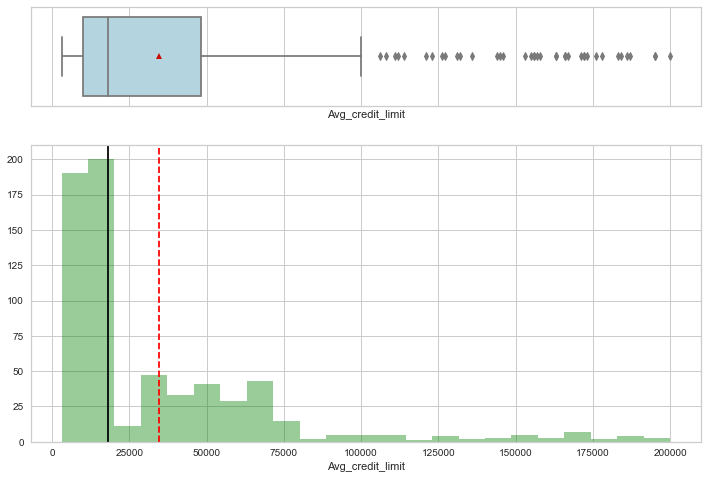

<IPython.core.display.Javascript object>

In [21]:
histogram_boxplot(df["Avg_credit_limit"])

**Observations:**
* There are quite a bit of outliers and the mean is greater than the median, giving a right skew.
* About 2/3 of the data comes from those with average credit limits of 25k or less.

### Total Credit Cards

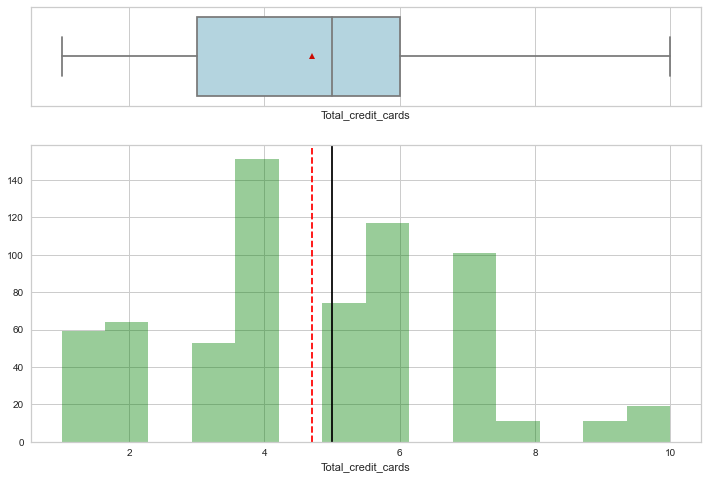

<IPython.core.display.Javascript object>

In [22]:
histogram_boxplot(df["Total_credit_cards"])

**Observations:**
* The median is at 5 cards, while the mean is slightly less.
* 4 cards on average has the greatest amount of customers out of the other card amounts. 

### Total Bank Visits

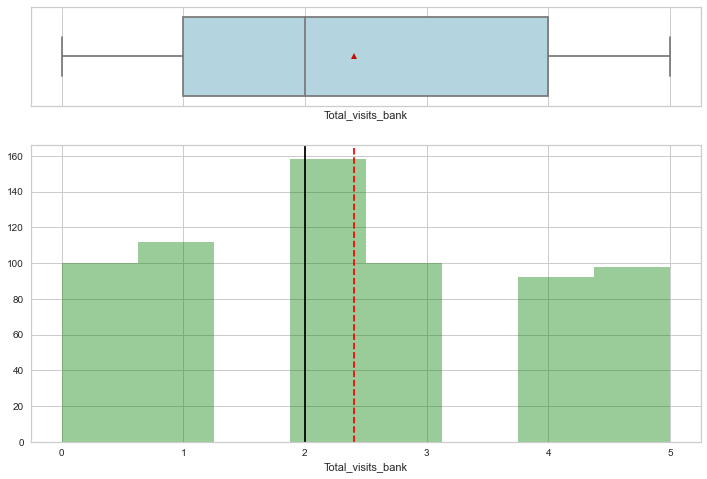

<IPython.core.display.Javascript object>

In [23]:
histogram_boxplot(df["Total_visits_bank"])

**Observations:**
* The mean is slightly greater than the median at about 2.3-2.4 bank visits per year.

### Total Online Visits

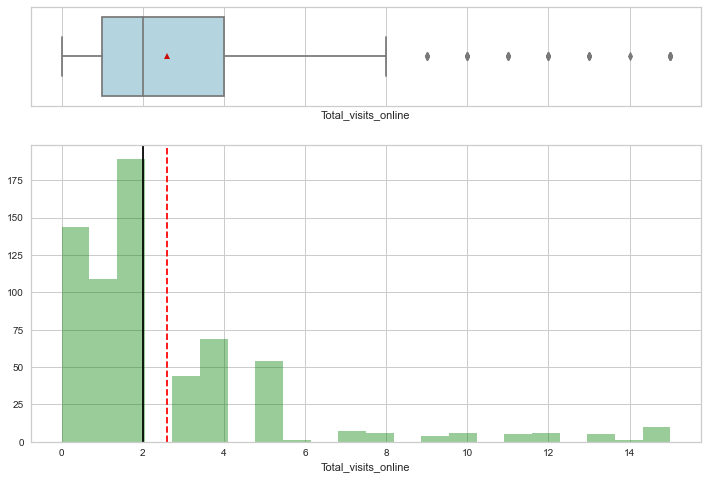

<IPython.core.display.Javascript object>

In [24]:
histogram_boxplot(df["Total_visits_online"])

**Observations:**
* Most customers use online banking 2 or less times in a year. 

### Total Calls Made

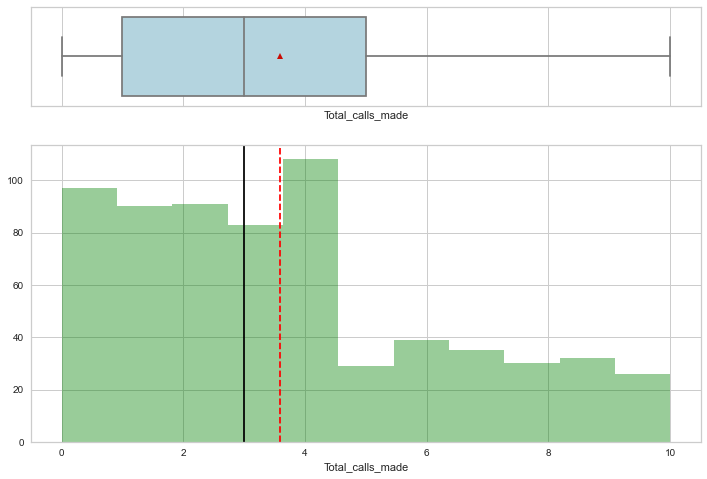

<IPython.core.display.Javascript object>

In [25]:
histogram_boxplot(df["Total_calls_made"])

**Observations:**
- The data is slightly skewed to the right with the mean being greater than the median.

# EDA
## Bivariate/Multi-variate

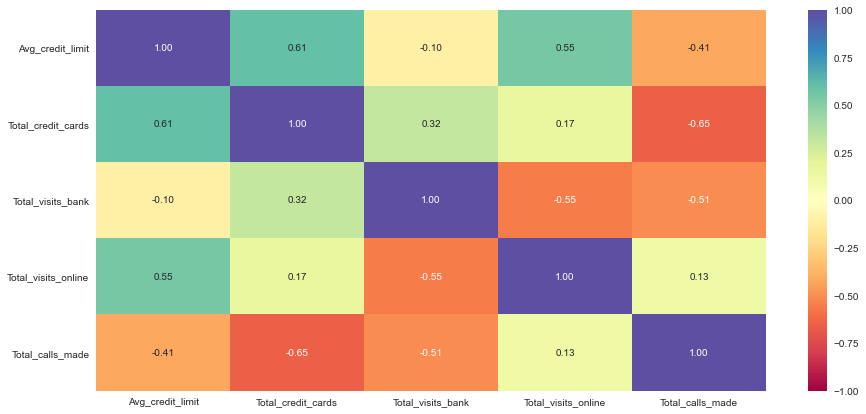

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

In [27]:
df.corr()

,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_credit_limit,1.000,0.609,-0.100,0.551,-0.414
Total_credit_cards,0.609,1.000,0.316,0.168,-0.651
Total_visits_bank,-0.100,0.316,1.000,-0.552,-0.506
Total_visits_online,0.551,0.168,-0.552,1.000,0.127
Total_calls_made,-0.414,-0.651,-0.506,0.127,1.000


<IPython.core.display.Javascript object>

**Observations:**
* `Total_calls_made` & `Total_credit_cards` have the greatest negatively correlated relationship at -0.651 followed by `Total_bank_visits` & `Total_visits_online` witg -0.552.
* The greatest positively correlated relationship between variables is 0.609 between `Avg_credit_limit` & `Total_credit_cards` followed by 0.551 between `Avg_credit_limit` & `Total_visits_online`.
* The lowest correlating relationships are bewtween `Avg_credit_limit` & `Total_visits_bank` at -.100 &  `Total_calls_made` & `Total_visits_online` at 0.127.

### Avg_credit_limit vs
**Total_credit_cards, 
Total_visits_bank, 
Total_visits_online, 
Total_calls_made**

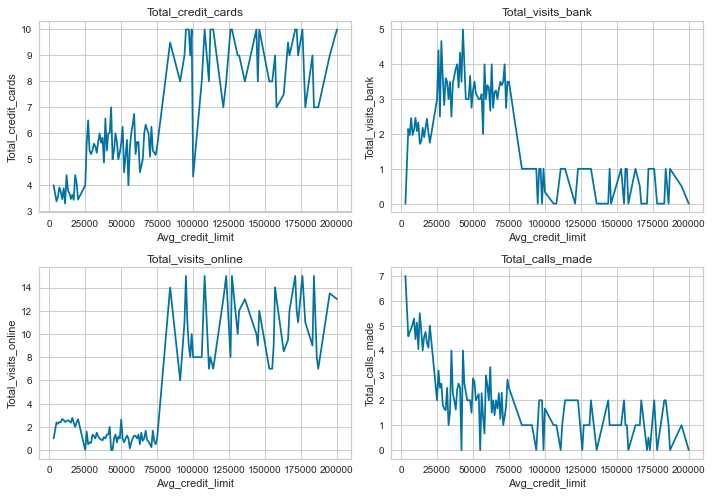

<IPython.core.display.Javascript object>

In [28]:
cols = df[
    [
        "Total_credit_cards",
        "Total_visits_bank",
        "Total_visits_online",
        "Total_calls_made",
    ]
].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.lineplot(df["Avg_credit_limit"], df[variable], palette="PuRd", ci=0)
    plt.tight_layout()
    plt.title(variable)
plt.show()



**Observations:**
* Those with a lower average credit limit tend to visit the physical bank more often than visiting online. Around 75k average credit limit it completely flips and those with a higher average credit limit tend to visit the bank online rather than in person. 
* Customers with an average credit limit under 25k call the bank the most.
* Not suprisingly, but for the most part, those with a higher average credit limit have a greater total number of credit cards.
* At about 100k, the Total Credit Cards a customer has dips aggressively to less than 5 cards. After, it goes back up to 10 cards.

### Total_credit_cards vs
**Avg_credit_limit,
Total_visits_bank, 
Total_visits_online, 
Total_calls_made**

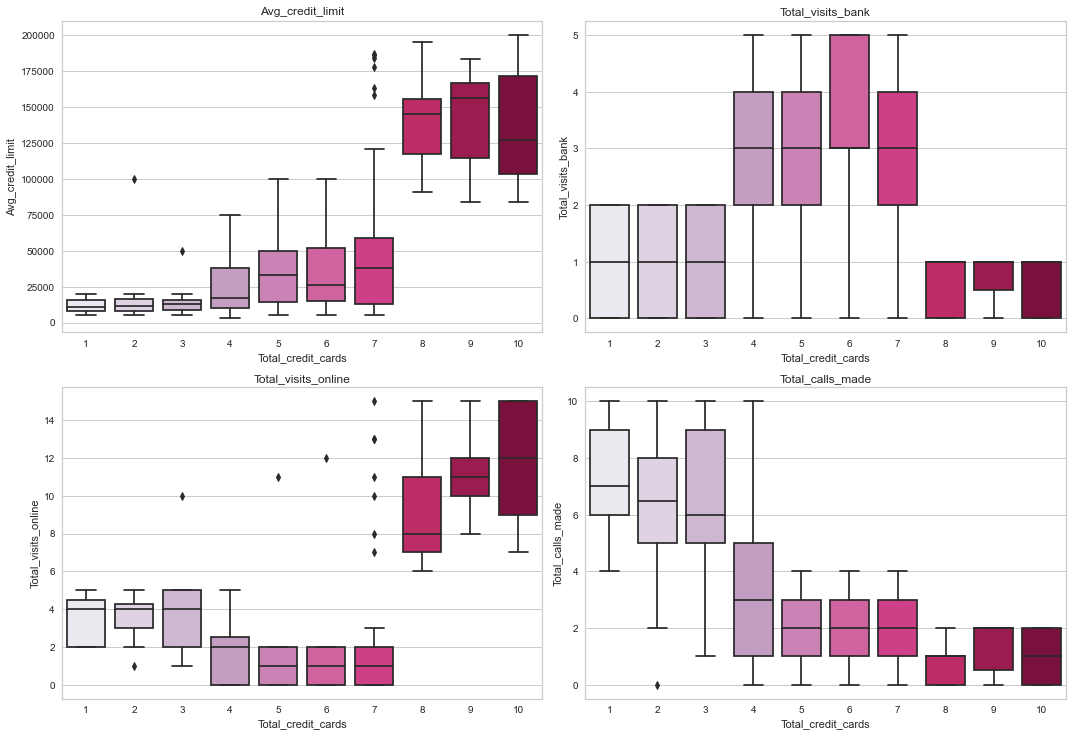

<IPython.core.display.Javascript object>

In [29]:
cols = df[
    [
        "Avg_credit_limit",
        "Total_visits_bank",
        "Total_visits_online",
        "Total_calls_made",
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(df["Total_credit_cards"], df[variable], palette="PuRd")
    plt.tight_layout()
    plt.title(variable)
plt.show()

**Observations:**
* Customers with 7 credit cards have many outliers for the both the average credit limit and the total online visits.
* For the average credit limit those with 1, 2, or 3 credit cards have almost identical boxplots with only the medians being different (due to outliers).
* For total bank visits per year, the max is 5 with only customers with 4, 5, 6, & 7 credit cards reaching that amount.
* For Total Bank Visits, those who have 1, 2, or 3 credit cards have identical boxplots, with the median being the exact same at 1 bank visit. The maximum visits to the bank that these credit card holders go is 2 times per year.
* Online visiting customers with a total of 7 credit cards has a handful of outliers.
* The medians for 1, 2, & 3 credit cards for online visits all have the same median. 
* Total online visits and total calls made seem to follow the pattern that the more credit cards you have, the more likely you frequent the bank online and make very few phone calls and vice versa.

### Total_visits_bank vs
**Total_visits_online, 
Total_calls_made**

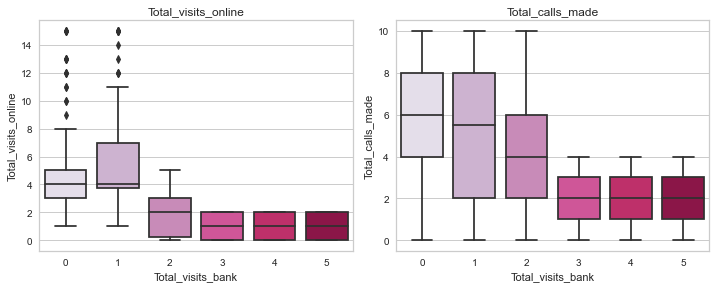

<IPython.core.display.Javascript object>

In [30]:
cols = df[
    [
        "Total_visits_online",
        "Total_calls_made",
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(df["Total_visits_bank"], df[variable], palette="PuRd")
    plt.tight_layout()
    plt.title(variable)
plt.show()

**Observations:**
- Not surprisingly, but those customers who had more online banking activity visited the bank in person less.
- Those who visited the bank less in person, had more calls with the bank.
- In both graphs, the boxplots for 3, 4, & 5 Total Bank Visits are identical to each other (for each individual graph).

### Total_visits_online vs
**Total_calls_made**

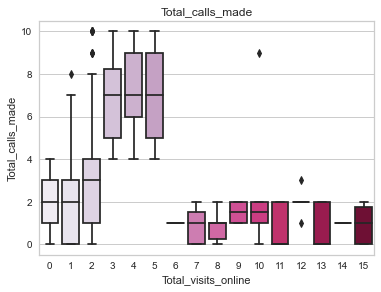

<IPython.core.display.Javascript object>

In [31]:
cols = df[
    [
        "Total_calls_made",
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(df["Total_visits_online"], df[variable], palette="PuRd")
    plt.tight_layout()
    plt.title(variable)
plt.show()

**Observations:**
- Those who made less online visits had more calls with the bank. 
- Customers who made 7 or more online visits typically only made a maximum or 2 calls to the bank, except for several outliers for 10 & 12 online visits.

### Binning Average Credit Limit for Multivariate Analysis

#### This was done just to see if we could pull anymore insight/information with the Average Credit Limit being easier to look at and compare to the other variable.

In [32]:
df["Avg_credit_limit"].describe()

count      660.000
mean     34574.242
std      37625.488
min       3000.000
25%      10000.000
50%      18000.000
75%      48000.000
max     200000.000
Name: Avg_credit_limit, dtype: float64

<IPython.core.display.Javascript object>

In [33]:
bins = [2999, 25000, 50000, 100000, 125000, 150000, 200000]
df["Avg_cred_bins"] = pd.cut(df["Avg_credit_limit"], bins)
df

,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made,Avg_cred_bins
0,100000,2,1,1,0,"(50000, 100000]"
1,50000,3,0,10,9,"(25000, 50000]"
2,50000,7,1,3,4,"(25000, 50000]"
3,30000,5,1,1,4,"(25000, 50000]"
4,100000,6,0,12,3,"(50000, 100000]"
...,...,...,...,...,...,...
655,99000,10,1,10,0,"(50000, 100000]"
656,84000,10,1,13,2,"(50000, 100000]"
657,145000,8,1,9,1,"(125000, 150000]"
658,172000,10,1,15,0,"(150000, 200000]"


<IPython.core.display.Javascript object>

In [34]:
df["Avg_cred_bins"].value_counts()

(2999, 25000]       391
(25000, 50000]      117
(50000, 100000]     113
(150000, 200000]     24
(125000, 150000]      8
(100000, 125000]      7
Name: Avg_cred_bins, dtype: int64

<IPython.core.display.Javascript object>

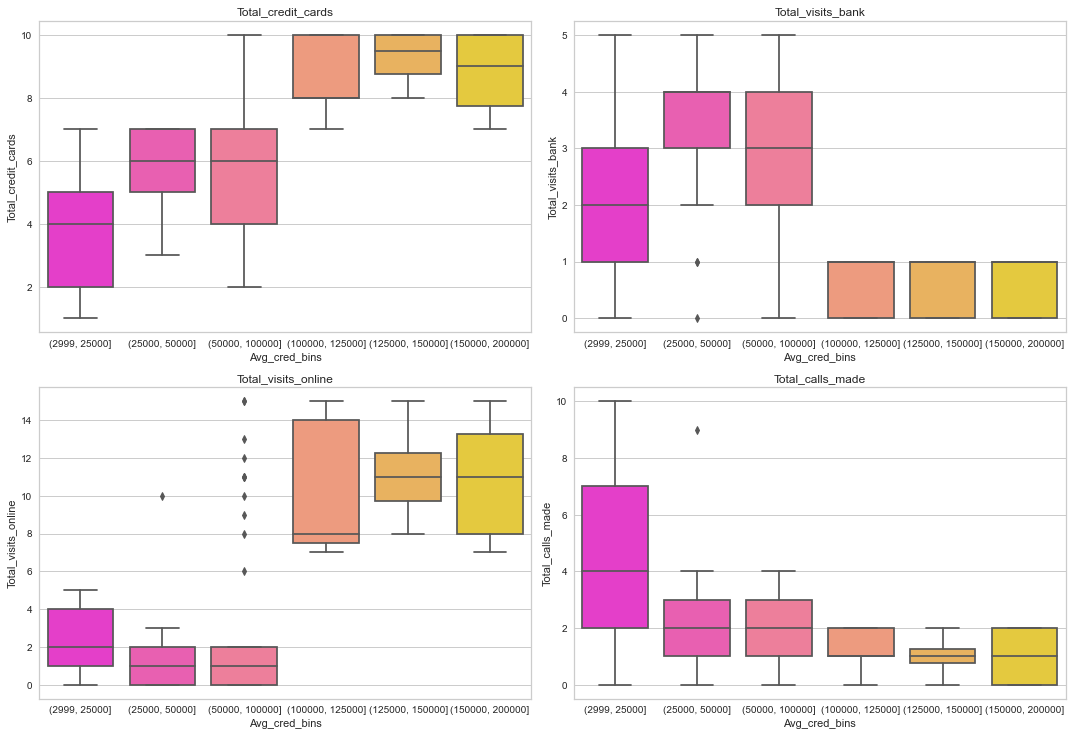

<IPython.core.display.Javascript object>

In [35]:
cols = df[
    [
        "Total_credit_cards",
        "Total_visits_bank",
        "Total_visits_online",
        "Total_calls_made",
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(df["Avg_cred_bins"], df[variable], palette="spring")
    plt.tight_layout()
    plt.title(variable)
plt.show()

**Observations:**
* Bin (3k - 25k]: This bin contains the most amount of customers, at 391. Those in this bin tend to have a lower amount of credit cards and prefer to either visit the bank in person or call.
* Bin (25k - 50k]: Preferred contact method is to visit the bank.
* Bin (50k - 75k]: There are a great amount of outliers present in total online visits. Their preferred method of contact is to visit the bank in person.
* Those with a higher credit limit tend to have more credit cards.
* Those in Bins (100k - 125k], (125k - 150k], & (150k - 200k] have identical boxplots for Total Bank Visits, with a maximum of only 1 bank visit per year. They also call into the bank a max of 2 times per year. These bins prefer to do their banking online. This is not surprising as there are only a total of 38 people in these bins. 
* It appears that the higher the range in Average Credit Limit, the less customers there are in that bin.

# Scale the Data

In [36]:
num_col = df.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [37]:
num_col

['Avg_credit_limit',
 'Total_credit_cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [38]:
# Creating dataframe from the scaled data
scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
scaled_df.head()

,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740,-1.249,-0.860,-0.547,-1.252
1,0.410,-0.788,-1.474,2.521,1.892
2,0.410,1.059,-0.860,0.134,0.146
3,-0.122,0.136,-0.860,-0.547,0.146
4,1.740,0.597,-1.474,3.202,-0.204


<IPython.core.display.Javascript object>

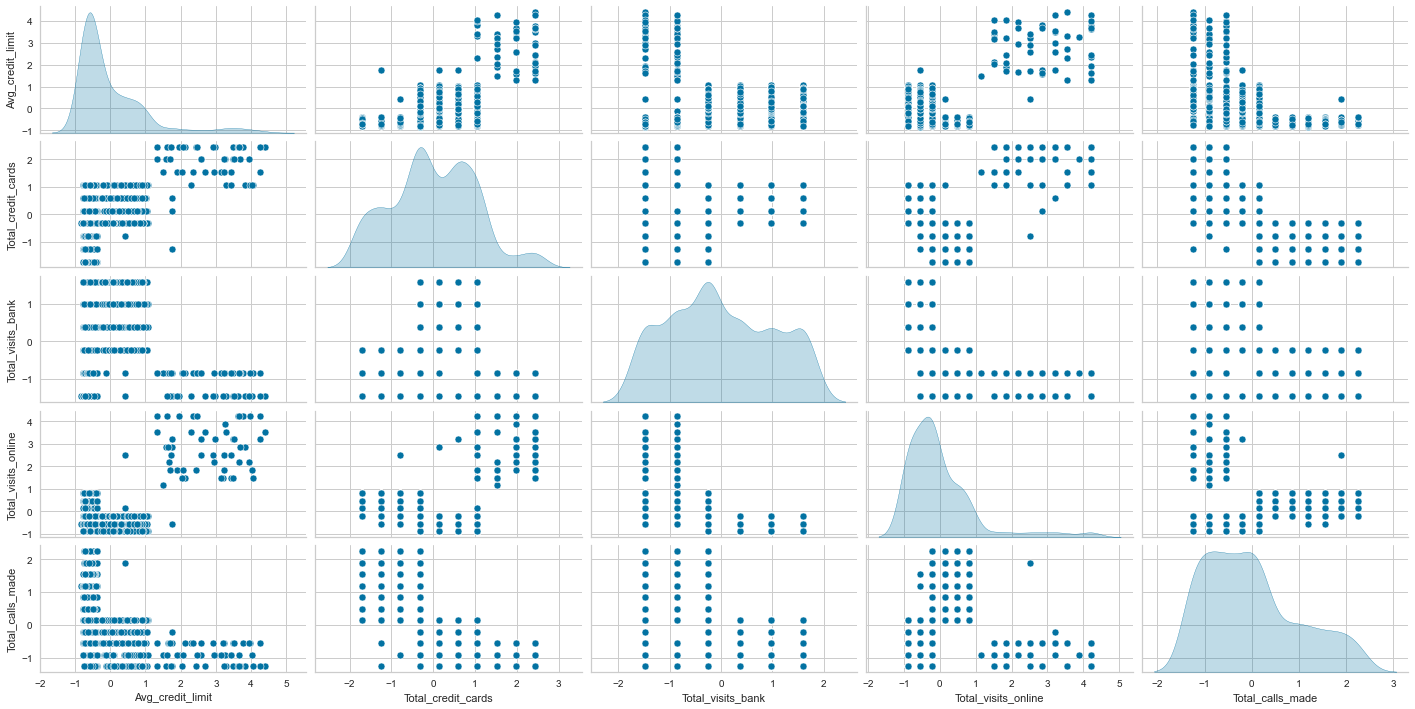

<IPython.core.display.Javascript object>

In [39]:
sns.pairplot(scaled_df, height=2, aspect=2, diag_kind="kde")

**Observations:**
* From just looking at the pairplot, it looks like marginals for `Avg_credit_limit` has at least 2 (possibly 3) different distrubtions, `Total_credit_cards` has at least 4 distrubtions, `Total_visits_bank` has at 5-6 distributions, `Total_visits_online` has at least 2 (possibly 3) distrbutions, & the marginals for `Total_calls_made` has at least 3 or 4 distributions.

# K-Means Clustering

## Elbow Method

For n_clusters (k) =: 1 	Average Distortion: 2.0069222262503614
For n_clusters (k) =: 2 	Average Distortion: 1.4571553548514269
For n_clusters (k) =: 3 	Average Distortion: 1.1466276549150365
For n_clusters (k) =: 4 	Average Distortion: 1.0463825294774465
For n_clusters (k) =: 5 	Average Distortion: 0.9907619712989449
For n_clusters (k) =: 6 	Average Distortion: 0.9429789712808515
For n_clusters (k) =: 7 	Average Distortion: 0.9148775127212979
For n_clusters (k) =: 8 	Average Distortion: 0.8893324990535055


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

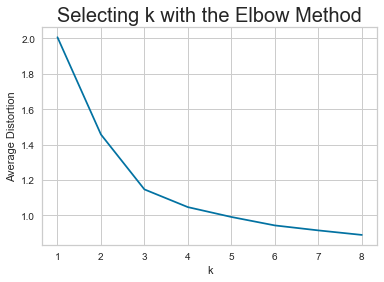

<IPython.core.display.Javascript object>

In [40]:
clusters = range(1,9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction = model.predict(scaled_df)
    distortion = (
        sum(
            np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("For n_clusters (k) =:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)


**Observations:**
* The appropriate value of k from the elbow curve appears to be 3 or 4.

### Silhouette Scores

For n_clusters = 2, silhouette score is 0.4184249666322083
For n_clusters = 3, silhouette score is 0.5157182558881671
For n_clusters = 4, silhouette score is 0.35566706193741826
For n_clusters = 5, silhouette score is 0.27174703610913536
For n_clusters = 6, silhouette score is 0.25581237463942674
For n_clusters = 7, silhouette score is 0.24843837619884387
For n_clusters = 8, silhouette score is 0.22595772292937708
For n_clusters = 9, silhouette score is 0.21922441874048715


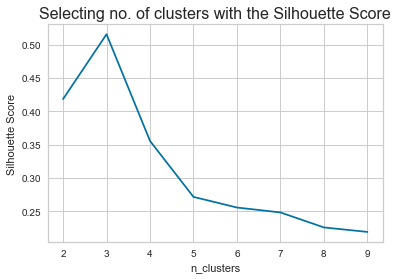

<IPython.core.display.Javascript object>

In [41]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.ylabel("Silhouette Score")
plt.xlabel("n_clusters")
plt.title("Selecting no. of clusters with the Silhouette Score", fontsize=16)

plt.plot(cluster_list, sil_score)

**Observations:**
* From the silhouette score, 3, 4, or possibly even 5 is a good value for k.

### Silhouette Plots for 5, 4, & 3 clusters

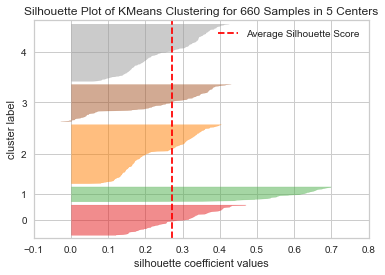

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [42]:
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

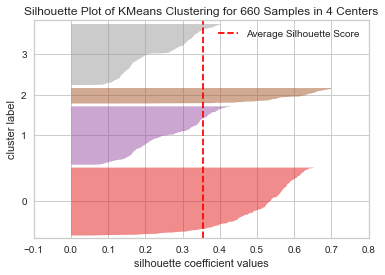

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [43]:
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

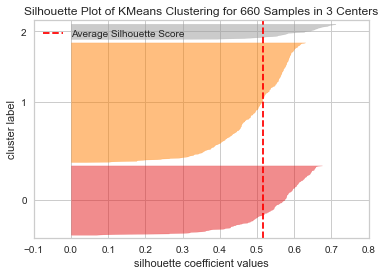

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [44]:
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

**Observations:**
* The optimal value for clusters would appear to be 4 clusters as the silhouette score is high enough and has more of a variability than 3 clusters. Even 5 would be a better option than 3 due to a more similar spread of data.

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(scaled_df)

KMeans(n_clusters=4, random_state=0)

<IPython.core.display.Javascript object>

In [46]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster Profiles

In [47]:
cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [48]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Total_credit_cards"].count().values
)

<IPython.core.display.Javascript object>

In [49]:
cluster_profile.style.highlight_max(color="lightpink", axis=0)

,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,31226.315789,5.478947,4.515789,1.010526,1.936842,190
1,12167.420814,2.393665,0.927602,3.574661,6.923077,221
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,35904.522613,5.522613,2.477387,0.969849,2.075377,199


<IPython.core.display.Javascript object>

**Observations:** 
* Under count_in_each_segment I have noticed that the total adds up to only 560, instead of 660. I am not sure why this is as this data has not had any outliers treated.

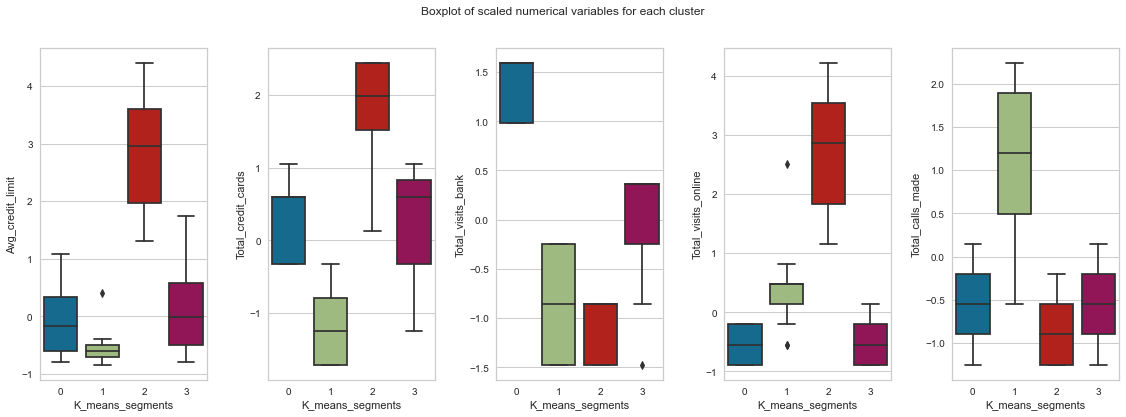

<IPython.core.display.Javascript object>

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=scaled_df[num_col[counter]],
        x=scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

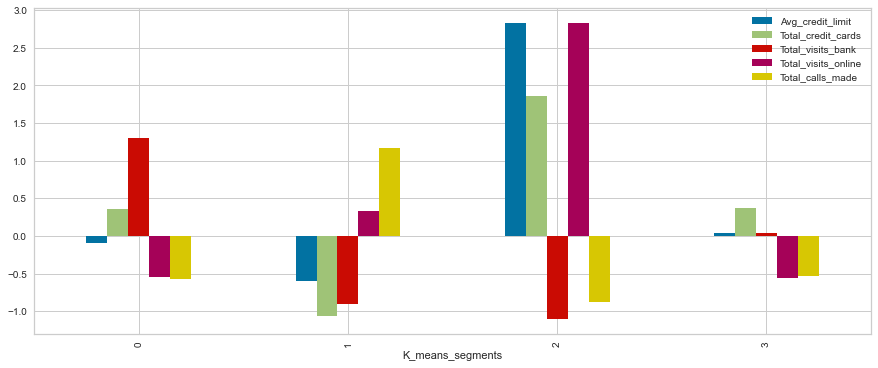

<IPython.core.display.Javascript object>

In [51]:
scaled_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

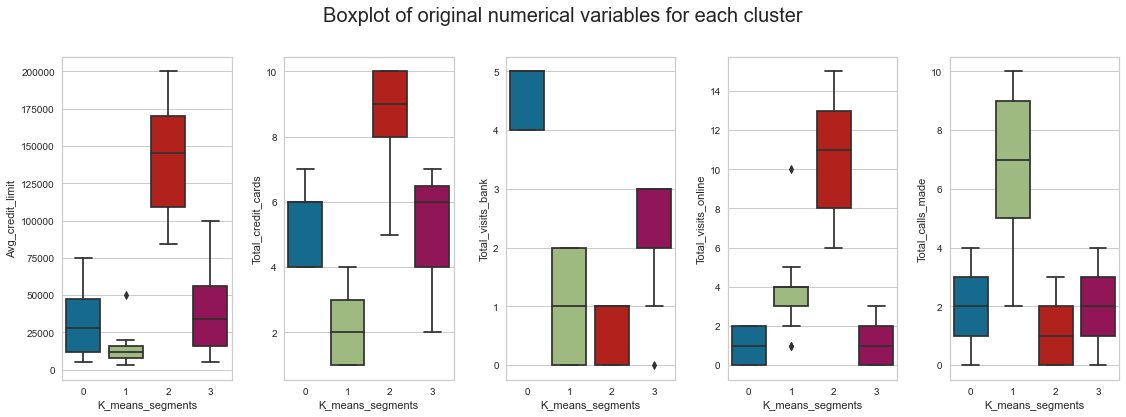

<IPython.core.display.Javascript object>

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Observations:**
* **Cluster 0:**
    - The Average Credit Limit for this cluster averages at about 30k, but goes up to 75k. This group would also be good to market "new money" (increasing credit limit) to. 
    - This group has a medium to high number of credit cards.
    - This cluster has the highest of Total Bank Visits, ranging from 4 to 5 a year. It could prove beneficial to market to this group of people by inviting them to come into a location to apply for a higher credit limit.
    - This cluster has a very low Total Online Visits. Getting feedback from these customers about their online experience with the bank could help improve these services.
    - Total Calls Made are relatively low as well, but may be the best way to contact the customer, as no other points of contact in this cluster go up to 4 points of contact.
    - There are 190 customers in this cluster.
    
    
* **Cluster 1:**
    - This cluster has the lowest range for Average Credit Limit, this cluster may be a good group to market to for increasing their credit limit. 
    - Total Credit Cards is low.
    - The maximum Total Bank Visits is only 2 times per year.
    - Total Visits online is low for this cluster.
    - Total Calls made range from 2-10, with the average being at 7 calls. This cluster would be the best to contact by phone for the marketing plan.
    - There are 221 customers in this cluster, making this the largest cluster.
    
    
* **Cluster 2:**
    - This cluster has the highest average credit limit, ranging from ~80k to 200k.
    - Total Credit Cards has the highest number of all the clusters, which was also indicated during EDA.
    - For Total Bank Visits, this cluster has the lowest of all the clusters, with customers visiting the bank 0 to 1 times a year. This may be a good cluster to reach out for improvement of in-person customer service to see if any improvements can be made.
    - The customers in this cluster prefer to access their account(s)/the bank by visiting online. This indicates that they are keeping up with their finaces the most. The best way to reach these customers would be through the website or app, as they use online banking more than any other cluster. Feedback via an online survey may prove to be beneifical.
    - Cluster 2 has the lowest average for Total Calls Made at only 1 call. The maximum is also the lowest of all the other cluster's maximums at 3 calls. Calling may not be the best way to contact the customer. 
    - There are only 50 customers in this cluster, making it the smallest of all the clusters. This cluster is still important though since they have the highest Average Credit Limit. 
    
    
* **Cluster 3:**
    - Average Credit Limits ranges from low to medium with the highest value being 100k. 
    - Total Credit Cards is medium-high indicating.
    - Total Bank Visits is low-medium & ranges between 1-3 visits. Compared to the other points of contact, relaying marketing information to people in this cluster in person could prove to be beneficial.
    - Total Online Visits is quite low, indicating  that this may not be the best way to get in touch with a customer.
    - The Total Calls made in this cluster exactly match those of cluster 1. These two clusters also have similar Average Credit Limits, Total Credit Cards, and Total Online Visitsm but their Total Bank Visits are the opposite of each other. 
    - There are 199 customers in this cluster.

# Hierarchical Clustering

In [53]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8003217596724628.
Cophenetic correlation for Euclidean distance and complete linkage is 0.9129097099636091.
Cophenetic correlation for Euclidean distance and average linkage is 0.9223890062144143.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9002680097925463.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6977868717123302.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8793862809889008.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9082424792622225.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9133895372063152.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8277398180790708.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6988083556432745.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8805316574702127.
Cophenetic co

<IPython.core.display.Javascript object>

In [54]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9223890062144143, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

### Exploring other linkage methods with Eucliden distance only

In [55]:
# list of linkage methods
linkage_methods = ["average", "centroid", "complete", "single", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for average linkage is 0.9223890062144143.
Cophenetic correlation for centroid linkage is 0.9166643480041976.
Cophenetic correlation for complete linkage is 0.9129097099636091.
Cophenetic correlation for single linkage is 0.8003217596724628.
Cophenetic correlation for ward linkage is 0.7826421011415847.
Cophenetic correlation for weighted linkage is 0.9002680097925463.


<IPython.core.display.Javascript object>

In [56]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9223890062144143, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations:**
- The cophenetic correlation is maximum with **Euclidean distance** and **average linkage** and is only slightly larger than the cophenetic correlation with cityblock & average linkage.

### Dendrograms for the different linkage methods

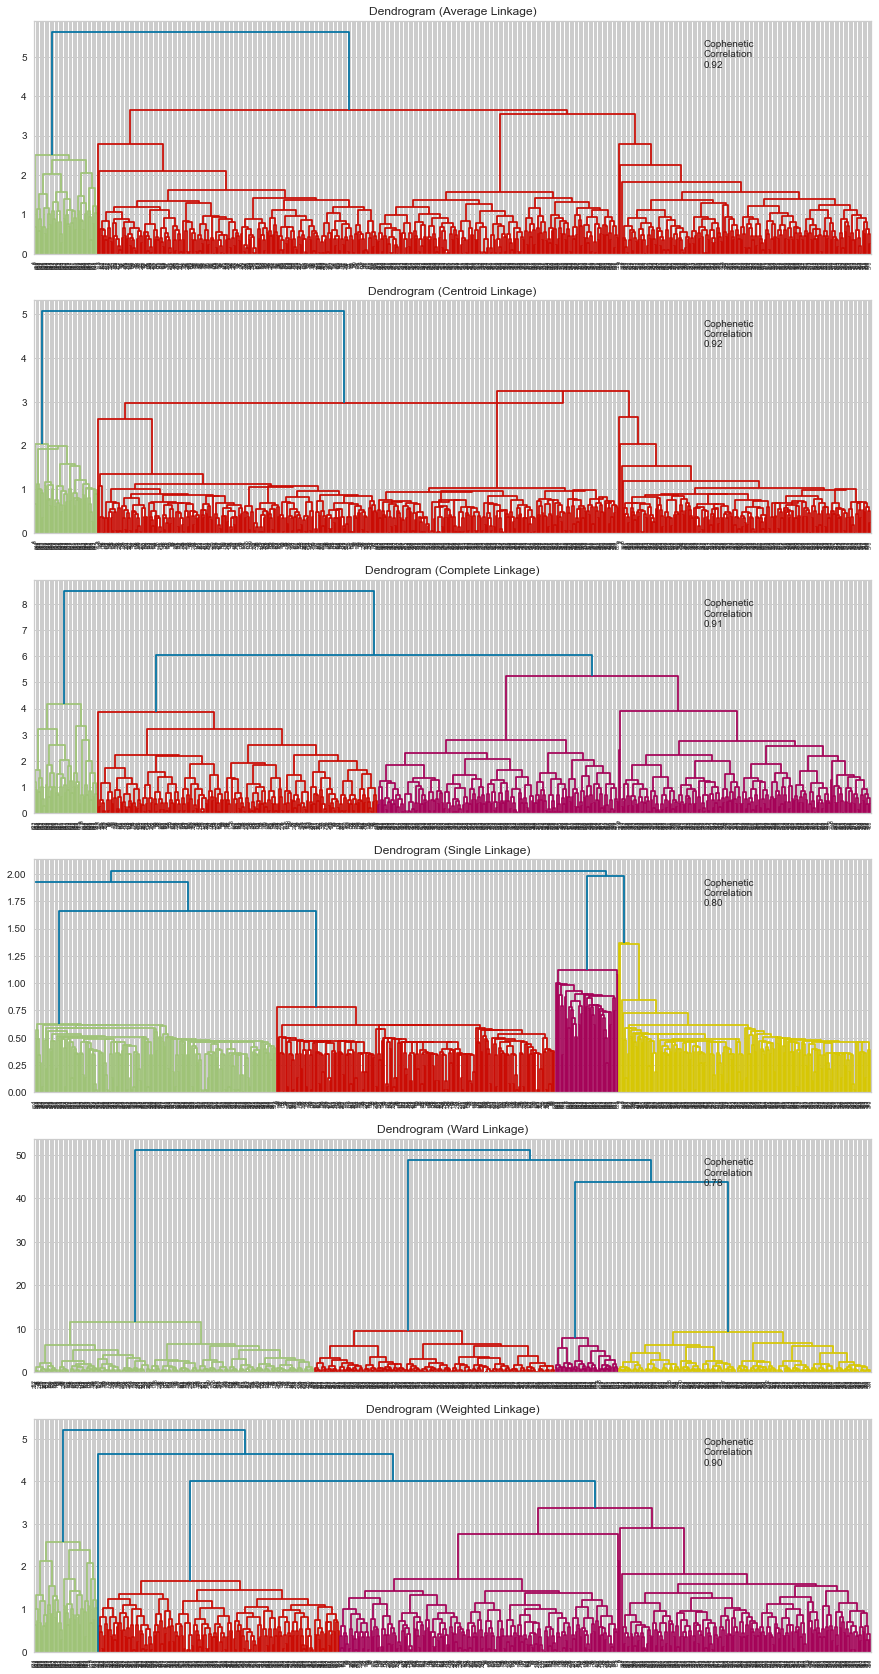

<IPython.core.display.Javascript object>

In [57]:
# list of linkage methods
linkage_methods = ["average", "centroid", "complete", "single", "ward", "weighted"]


# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations:**
* Both **Average linkage** & **Centroid Linkage** have the highest cophenetic correlation at 0.91.
* We will move forward dwith **Average Linkage** with 6 clusters. 
* **Ward linkage** shows distinct & separate clusters.

### Creating 6 no. of clusters with Average Linkage

In [58]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="average")
HCmodel.fit(scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=6)

<IPython.core.display.Javascript object>

In [59]:
scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

#### Cluster Profiling

In [60]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [61]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Total_credit_cards"].count().values
)

<IPython.core.display.Javascript object>

In [62]:
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following Average Credit Limits are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Avg_credit_limit"].unique())
    print()

In cluster 4, the following Average Credit Limits are present:
[100000]

In cluster 5, the following Average Credit Limits are present:
[50000]

In cluster 2, the following Average Credit Limits are present:
[50000 30000 15000 16000 10000  8000 19000 13000 20000  5000 18000 12000
 14000  7000 17000  6000 11000  9000 49000 67000 61000 75000 56000 72000
 70000 51000 73000 69000 40000 65000 48000 46000 74000 39000 52000 47000
 71000 59000 64000 45000 54000 31000 27000 36000 25000 57000 66000 35000
 26000 38000 34000 58000 29000 68000 42000 33000 62000 37000 32000 60000
 44000 55000 63000]

In cluster 0, the following Average Credit Limits are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 183000 111000 112000 132000  95000 172000
  99000 145000 167000]

In cluster 1, the following Average

<IPython.core.display.Javascript object>

**Observations:**
- **Ward linkage** gives us more distinct & separated clusters, as seen from the dendrogram above. We will see if we get better variability for the clusters using this method
- The appropriate number of clusters appears to be 4 clusters.

### Trying  4 no. of clusters with Ward Linkage

In [63]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(scaled_df)

AgglomerativeClustering(n_clusters=4)

<IPython.core.display.Javascript object>

In [64]:
scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

#### Cluster Profiling

In [65]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [66]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Total_credit_cards"].count().values
)

<IPython.core.display.Javascript object>

In [67]:
# let's see the names of the countries in each cluster
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following Average Credit Limits are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Avg_credit_limit"].unique())
    print()

In cluster 2, the following Average Credit Limits are present:
[100000  50000  30000  15000  16000  10000   8000  19000  13000  20000
   5000  18000  12000  14000   7000  17000   6000  11000   9000  49000
  67000  61000  75000  56000  72000  70000  51000  73000  69000  40000
  65000  48000  46000  74000  39000  52000  47000  71000  59000  64000
  45000  54000  31000  27000  36000  25000  57000  66000  35000  26000
  38000  34000  58000  29000  68000  42000  33000  62000  37000  32000
  60000  44000  55000  63000]

In cluster 0, the following Average Credit Limits are present:
[50000 20000  5000  3000 10000 13000 11000  9000  6000  8000 15000 19000
 16000 18000 17000 14000 12000  7000]

In cluster 3, the following Average Credit Limits are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 

<IPython.core.display.Javascript object>

**Observations:**
- Using **Ward Linkage** with **4 clusters** gives a better variability throughout the clusters.

In [68]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightpink", axis=0)

,Avg_credit_limit,Total_credit_cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,12167.420814,2.393665,0.927602,3.574661,6.923077,1,221
1,31226.315789,5.478947,4.515789,1.010526,1.936842,0,190
2,35904.522613,5.522613,2.477387,0.969849,2.075377,3,199
3,141040.000000,8.740000,0.600000,10.900000,1.080000,2,50


<IPython.core.display.Javascript object>

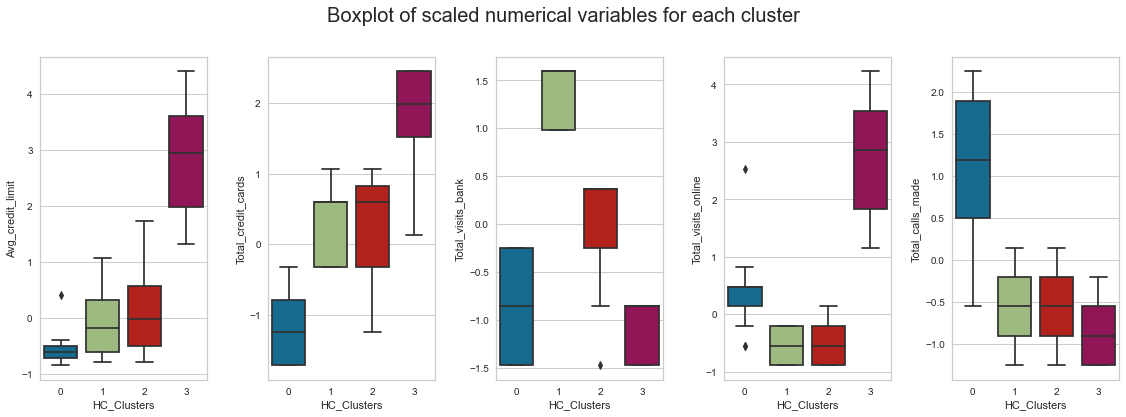

<IPython.core.display.Javascript object>

In [69]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=scaled_df[num_col[counter]],
        x=scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

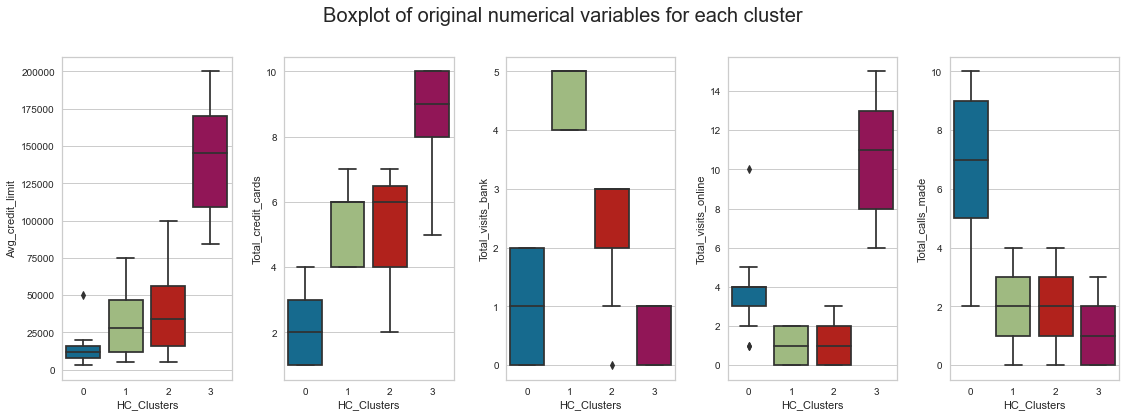

<IPython.core.display.Javascript object>

In [70]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights
* **Cluster 0:**
    - Those in cluster 0 have the smallest range of the Average Credit Limit. There is an outlier present.
    - Total Credit Cards has the smallest range in credit cards too, ranging from 1 to 4.
    - Total Bank Visits has a low number, with the mean at 1. 
    - Total Online Visits are relatively low to medium as well, with a few outliers.
    - Cluster 0 makes the most calls to the bank than any other cluster, with its minimum values being the median of clusters 1 & 2. It is the only cluster to reach more than 4 calls.
    - There are 221 counts in this cluster.
   
   
* **Cluster 1:**
    - This cluster has the second lowest Average Credit Limit, maxing out at 75k.
    - Total Credit Cards has medium to high credit cards, with a minimum of 4 cards per customer.
    - Cluster 1 has the highest bank visits and the only cluster to get above 3 visits.
    - Total Bank Visits is quite low ranging from 0-2.
    - Total Calls Made is relatively low, ranging from 0 to 4 calls.
    - There are 190 counts in this clusters.
    
    
* **Cluster 2:**
     - Average Credit Limit maxes out at 100k.
     - Total Credit Cards has an average of 6 cards, ranging from 2 to 7 credit cards.
     - Cluster two has a medium Total Bank Visits, reaching up to 3.
     - The Total Bank Vists is very similar to cluster 1's, except it goes up to 3 visits, still indicating a low amount.
     - Total Calls Made is identical to cluster 1, maxing out at 4 calls.
     - There are 50 counts in this cluster.
     
     
* **Cluster 3:**
    - Cluster 3 has the highest dollar amount for Average Credit Limit. It is the only cluster to go above 100k & reach 200k.
    - This cluster has the greatest amount of credit cards per person than any other cluster, with being the only cluster to go above 7 credit cards all the way to 10.
    - Not as many people visit the bank in person, resulting in the lowest bank visits, up to only 1 visit a year.
    - Those in cluster 3 tend to use online banking more than any other cluster, ranging from 6 to 15 visits per year.
    - This cluster also has the smallest maximum value of calls made, ranging from only 0 to 3 calls.
    - There are 199 counts in this cluster

# PCA
### Due to the small number of features, feature extraction via PCA will not be performed.

# Business Recommendations

* Clusters 0 , 1, & 3  would be the main clusters to targets for marketing “new money” (increased credit limit) to as they have lower average credit limits.
  - From personal experience (in a previous personal banker role), running a soft credit check to see if these customers pre-qualify for an increase in their credit limit could be an incentive to bring in more business.  


* Cluster 1 should be the main target of marketing calls, as they call the bank more than any other group.


* With cluster 1 being the largest cluster with 221 customers, adding a customer satisfaction survey at the end of calls could be highly beneficial for making improvements to the service delivery model.


* Cluster 2 has a low count for total bank visits and calls made, but the highest for total online visits. Although this cluster only contains 50 customers, putting a customer satisfaction and/or customer service improvement on the bank’s website could be a good way to get feedback. 


* As those in Clusters 0 & 3 tend to visit the bank more than other clusters, marketing via snail mail could be a good tool to invite them in to visit the bank and increase their average limit. In this letter, it can also state if they pre-qualify for an increase.


* Targeting these customers by their seemingly prefer method of contact (in-person, online, phone) would be the best way to market to them and get feedback on improving customer service. 

